In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, GRU, Conv1D, MaxPooling1D, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
dt = pd.read_excel("dataset.xlsx")
dt.to_csv("dt_dataset.csv", index=False)

In [30]:
dt = pd.read_csv("dt_dataset.csv")
dt.head()
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Time        9999 non-null   float64
 1   RSRP        9999 non-null   float64
 2   RSRQ        2999 non-null   float64
 3   MCS         9999 non-null   int64  
 4   CQI         9999 non-null   int64  
 5   Throughput  9999 non-null   float64
 6   Delay       9999 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 546.9 KB


In [31]:
dt = dt.dropna()

In [32]:
null_count = dt.isnull().sum()
print(null_count[null_count>0])

Series([], dtype: int64)


In [33]:
dt.shape

(2999, 7)

In [34]:
num_zeros = (dt['Throughput']==0).sum()

total_samples = len(dt)

print(f"Number of zero throughput samples: {num_zeros}")
print(f"Percentage of zeros: {num_zeros / total_samples * 100:.2f}%")

Number of zero throughput samples: 425
Percentage of zeros: 14.17%


In [35]:
dt

,Time,RSRP,RSRQ,MCS,CQI,Throughput,Delay
0,0.001,0.000,0.0000,0,0,0.000000,0.000000
1,0.002,0.000,0.0000,0,0,0.000000,0.000000
2,0.003,0.000,0.0000,0,0,0.000000,0.000000
3,0.004,0.000,0.0000,0,0,0.000000,0.000000
4,0.005,0.000,0.0000,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...
2994,2.995,-163.669,-43.3408,0,0,0.000695,0.000156
2995,2.996,-163.669,-43.3408,0,0,0.000695,0.000156
2996,2.997,-163.669,-43.3408,0,0,0.000695,0.000156
2997,2.998,-163.669,-43.3408,0,0,0.000695,0.000156


In [36]:
dt['Throughput'].mean()

np.float64(7261.1811469690565)

In [37]:
dt['Delay'].mean()

np.float64(0.00010601667222407471)

In [38]:
dt

,Time,RSRP,RSRQ,MCS,CQI,Throughput,Delay
0,0.001,0.000,0.0000,0,0,0.000000,0.000000
1,0.002,0.000,0.0000,0,0,0.000000,0.000000
2,0.003,0.000,0.0000,0,0,0.000000,0.000000
3,0.004,0.000,0.0000,0,0,0.000000,0.000000
4,0.005,0.000,0.0000,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...
2994,2.995,-163.669,-43.3408,0,0,0.000695,0.000156
2995,2.996,-163.669,-43.3408,0,0,0.000695,0.000156
2996,2.997,-163.669,-43.3408,0,0,0.000695,0.000156
2997,2.998,-163.669,-43.3408,0,0,0.000695,0.000156


In [39]:
columns_to_check = ["RSRP", "RSRQ", "CQI", "MCS", "Throughput","Delay"]
dt_iqr = dt.copy()

for i in columns_to_check:
    Q1 = dt_iqr[i].quantile(0.25)
    Q3 = dt_iqr[i].quantile(0.75)
    IQR = Q3-Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    dt_iqr = dt_iqr[(dt_iqr[i] >= lower) & (dt_iqr[i] <= upper)]

print(f"Original size: {dt.shape}")
print(f"Filtered size: {dt_iqr.shape}")

Original size: (2999, 7)
Filtered size: (2200, 7)


In [42]:
features = ["RSRP", "Delay"]
target = ["Throughput"]

X = dt_iqr[features]
y = dt_iqr[target]

X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(X, y, test_size=0.2, shuffle=False)

In [43]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_x.fit_transform(X_train_raw)
y_train_scaled = scaler_y.fit_transform(y_train_raw)

X_val_scaled = scaler_x.transform(X_val_raw)
y_val_scaled = scaler_y.transform(y_val_raw)

sequence_length = 100

def create_sequences(X, y, seq_len=40):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_val, y_val = create_sequences(X_val_scaled, y_val_scaled, sequence_length)

In [44]:
X_train.shape

(1660, 100, 2)

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 100, 128)       │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 100, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,009 (277.38 KB)

 Trainable params: 71,009 (277.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 1.4477e-04 - val_loss: 5.5512e-06
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 8.7185e-07 - val_loss: 7.9882e-06
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 6.2798e-07 - val_loss: 9.1659e-06
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.9855e-07 - val_loss: 1.0129e-05
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.6972e-07 - val_loss: 9.0470e-06
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.9264e-07 - val_loss: 9.6879e-06
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.5775e-07 - val_loss: 1.0365e-05
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.8984e-07 - val_loss: 1.0257e-05
Epoch 9/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.5219e-07 - val_loss: 9.9112e-06
Epoch 10/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.4390e-07 - val_loss: 1.0979e-05
Epoch 11/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.1501e-0

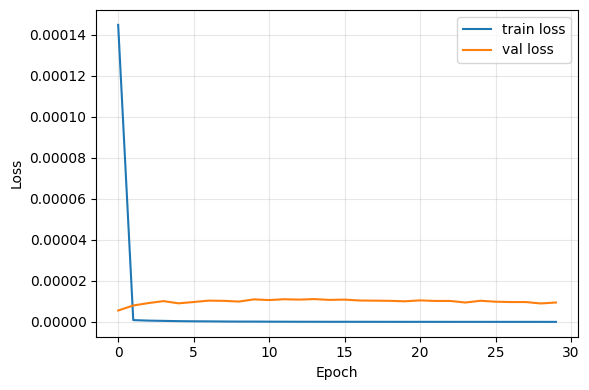

In [45]:
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(128, 3, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_lstm_model.add(Conv1D(64, 3, activation='relu', padding='same'))
cnn_lstm_model.add(MaxPooling1D(2))
cnn_lstm_model.add(Dropout(0.2))
cnn_lstm_model.add(LSTM(64, return_sequences=True))
cnn_lstm_model.add(LSTM(32))
cnn_lstm_model.add(Dense(1))

cnn_lstm_model.compile(optimizer='adam', loss='mse')
cnn_lstm_model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = cnn_lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)

# Inspect available keys
print(history.history.keys())  # typically: dict_keys(['loss', 'val_loss', ...])

# Plot loss curves
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [47]:
# Predict and evaluate
preds = cnn_lstm_model.predict(X_val)
preds_inverse = scaler_y.inverse_transform(preds)
y_val_inverse = scaler_y.inverse_transform(y_val)
df_results = pd.DataFrame({
    'predicted_throughput': preds_inverse.flatten(),
    'actual_throughput': y_val_inverse.flatten()
})

# Compute metrics
mae = mean_absolute_error(y_val_inverse, preds_inverse)
mape = np.mean(np.abs((y_val_inverse - preds_inverse) / y_val_inverse)) * 100
mse = mean_squared_error(y_val_inverse, preds_inverse)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_inverse.ravel(), preds_inverse.ravel())

print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape}%")
print(f"MSE:  {mse}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
MAE:  0.0030
MAPE: 3.054382626715875e-05%
MSE:  9.456701836591757e-06
RMSE: 0.0031
R²:   0.0


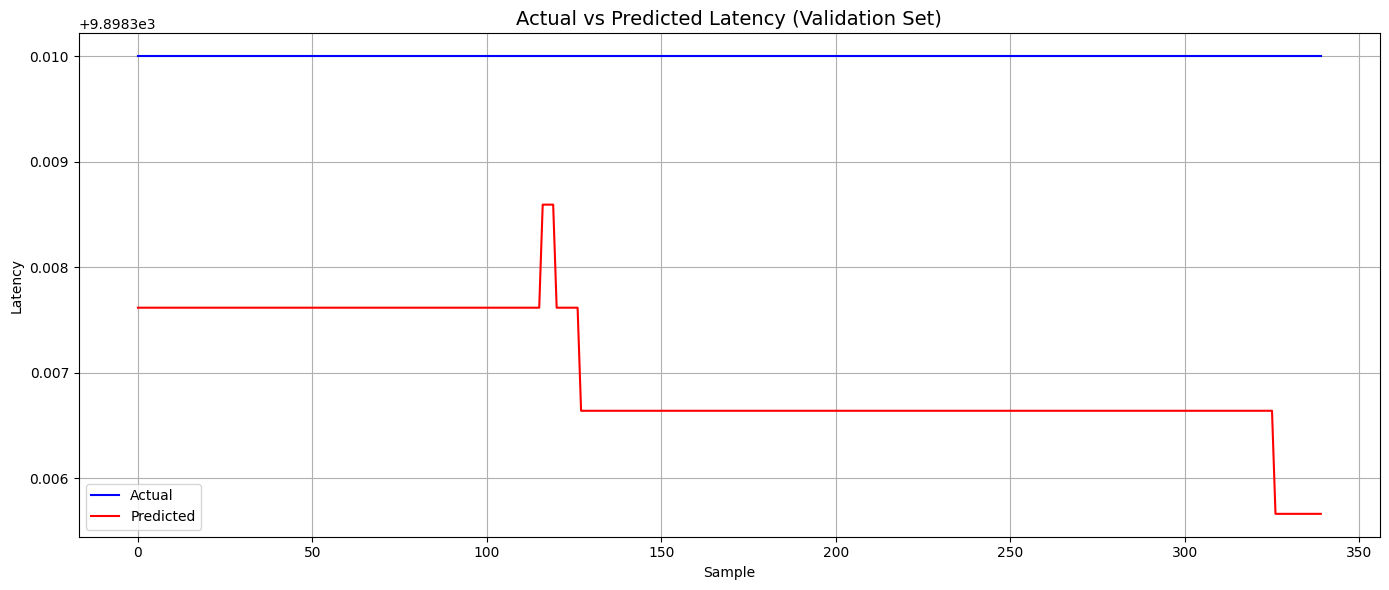

In [48]:
plt.figure(figsize=(14, 6))
plt.plot(y_val_inverse, label='Actual', color='blue')
plt.plot(preds_inverse, label='Predicted', color='red')
plt.title("Actual vs Predicted Latency (Validation Set)", fontsize=14)
plt.xlabel("Sample")
plt.ylabel("Latency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
preds_inverse.shape


(811, 1)

In [26]:
y_val_inverse.shape

(811, 1)